In [1]:
using Revise, HarmonicBalance, Plots
include("../plotting.jl");
result = HarmonicBalance.load("/home/hrochan/Downloads/2_Duff_lc_F0_overdamped.jld2")

┌ Info: Precompiling HarmonicBalance [e13b9ff6-59c3-11ec-14b1-f3d2cc6c135e]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Package HarmonicBalance does not have Plots in its dependencies:
│ - If you have HarmonicBalance checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HarmonicBalance
└ Loading Plots into HarmonicBalance from project dependency, future warnings for HarmonicBalance are suppressed.
┌ Warning: You are using Matplotlib 3.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to instal

A steady state result for 500 parameter points

Solution branches:   2202
   of which real:    10
   of which stable:  4

Classes: stable, physical, Hopf, binary_labels


# Solve the system with the simple ansatz

In [2]:
@variables γ, F, α, ω0, F0, η, J, ω, t, θ, x(t), y(t);
diff_eq = DifferentialEquation([d(x,t,2) + γ * d(x,t) + ω0^2 * x + α*x^3+ J*ω0*(x-y) - F0*cos(ω*t+θ), 
            d(y,t,2) + γ * d(y,t) + ω0^2 * y + α*y^3 + J*ω0*(y-x) - η*F0*cos(ω*t+θ)], [x,y])

add_harmonic!(diff_eq, x, ω)
add_harmonic!(diff_eq, y, ω)
harmonic_eqs = get_harmonic_equations(diff_eq)

fixed_parameters = (
    ω0 => 1 , # natural frequency of separate modes
    γ => 1E-2,    # damping
    J => 3E-2,   # coupling term
    α => 1E-3,   # Kerr nonlinearity
    ω => 1. + 3E-2,  # pump frequency, resonant with antisymmetric mode
    η => -0.1,      # pumping leaking to site 2  (F2 = ηF1)
    F0 => 1,      # pump amplitude (overriden in sweeps)
    θ => 0
)

varied = F0 => LinRange(0.1, 0.35, 200)

result0 = get_steady_states(harmonic_eqs, varied, fixed_parameters, random_warmup=true)

Tracking 81 paths... 100%|██████████████████████████████| Time: 0:00:13
  # paths tracked:                  81
  # non-singular solutions (real):  11 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         11 (0)


A steady state result for 200 parameter points

Solution branches:   11
   of which real:    3
   of which stable:  2

Classes: stable, physical, Hopf, binary_labels


# compare extended ansatz to FT components of a time-dependent simulation

In [3]:
import HarmonicBalance.TimeEvolution: ODEProblem, DifferentialEquations.solve, ParameterSweep
using NumericalIntegration

fft_window(data) = HarmonicBalance.TimeEvolution.DSP.Windows.bartlett(length(data))

function steady_fft(; F0fin, θfin=0.0, ω_drive = 1.03, T = 2E4, dt = 0.1)
    
# first a sweep followed by free time-evolution
    initial_state = copy(result0[50][1])
    initial_state[F0] = F0fin
    initial_state[ω] = ω_drive
    #F0_lims = (0.1, F0fin)

    #sweep_F0 = ParameterSweep(F0 => F0_lims, (0,T))
    
    sweep_θ = ParameterSweep(θ => (0.0, θfin), (0.5T,1.5T))
    TDproblem = ODEProblem(harmonic_eqs, initial_state, sweep=sweep_θ, timespan=(0,4*T))
    TDsoln = solve(TDproblem, saveat=dt);
    
    t1 = Int(round(0.5*length(TDsoln.t)))
    ts = TDsoln.t[t1:end]

    x_lab = getindex.(TDsoln.u,1)[t1:end] .* cos.(ts*ω_drive) + getindex.(TDsoln.u,2)[t1:end] .* sin.(ts*ω_drive);
    y_lab = getindex.(TDsoln.u,3)[t1:end] .* cos.(ts*ω_drive) + getindex.(TDsoln.u,4)[t1:end] .* sin.(ts*ω_drive);

    fft_x = HarmonicBalance.FFT(x_lab, ts, window=fft_window(x_lab));
    fft_y = HarmonicBalance.FFT(y_lab, ts, window=fft_window(y_lab));
    
    norm = ts[end] - ts[1]
    fft_x[1][1] *= norm
    fft_y[1][1] *= norm
    
    
    return fft_x, fft_y

end

function peak_int(fft, range)
    indices = range[1] .< fft[2] .< range[2]
    peak_pos = argmax(abs.(fft[1][1])[indices])
    integrate(fft[2][indices], abs.(fft[1][1])[indices]) / (2pi), fft[2][indices][peak_pos]
end

function steady_peaks(; F0fin, ω_drive=1.03, T=2E4, dt=0.05)
    fft = steady_fft(; F0fin=F0fin, ω_drive=ω_drive, T=T, dt=dt)
    
    ranges = [(1.00, 1.02), (1.02,1.04), (1.04,1.055)]
    
    res = [[peak_int(fft[1],r)..., peak_int(fft[2], r)...] for r in ranges]
    
end

steady_peaks (generic function with 1 method)

In [4]:
steady_peaks(F0fin  = 0.2, ω_drive = 1.03)

3-element Vector{Vector{Float64}}:
 [2.5064937345476537, 1.013946494020851, 1.92968047581966, 1.013946494020851]
 [2.8189396220685703, 1.02996857649802, 5.2911880318326165, 1.02996857649802]
 [1.795766321528245, 1.045990658975189, 2.523547437908922, 1.045990658975189]

In [5]:
F0s = LinRange(0.18,0.27,10)
pks = [steady_peaks(F0fin=F) for F in F0s];

## plotting

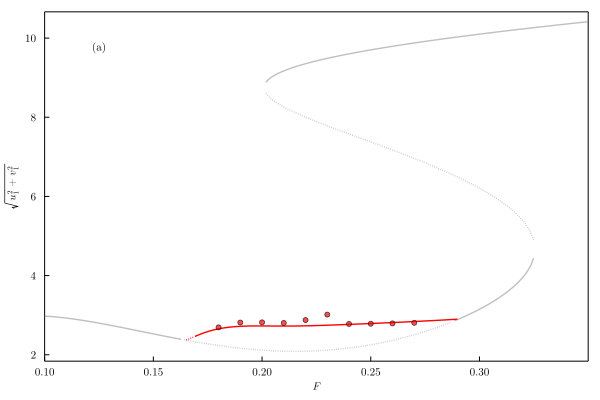

In [6]:
HarmonicBalance.Plots.default(linewidth=1.4, markersize=3,xlabel= "\$ F \$")

p1 =plot1D(result0, x="F0", y="sqrt(u1^2+v1^2)", opacity=0.5, ylabel="\$ \\sqrt{u_1^2+v_1^2} \$", c=:gray)
plot1D(result, x="F0", y="sqrt(u1^2+v1^2)", plot_only=["physical"], add=true, branches=[4], c=:red,
xlim=(0.1,0.35))
annotate!((0.1,0.9), text("(a)", 7, "Computer Modern"))

RK_peaks = [p[2][1] for p in pks]
Plots.scatter!(F0s, RK_peaks, c=:red, opacity=0.7)

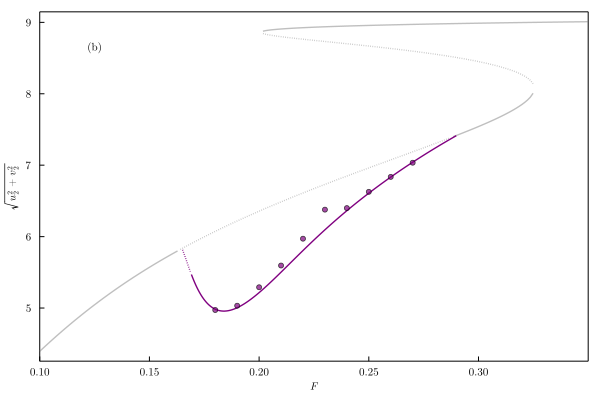

In [7]:
p2 =plot1D(result0, x="F0", y="sqrt(u2^2+v2^2)", opacity=0.5, ylabel="\$ \\sqrt{u_2^2+v_2^2} \$", c=:gray, xlim=(0.1,0.35))
plot1D(result, x="F0", y="sqrt(u4^2+v4^2)", plot_only=["physical"], add=true, branches=[4], c=:purple)
annotate!((0.1,0.9), text("(b)", 7, "Computer Modern"))

RK_peaks = [p[2][3] for p in pks]
Plots.scatter!(F0s, RK_peaks, c=:purple, opacity=0.7)

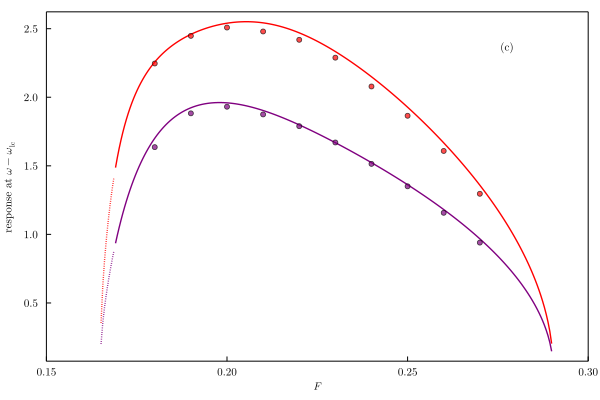

In [8]:
default(xlim=(0.15,0.3))

p3 = plot1D(result, x="F0", y="sqrt(u2^2+v2^2)", ylabel="oscillator 1, left sidepeak", 
    plot_only=["physical"], branches=[4], c=:red, xlim=(0.15,0.3),xticks=[0.15,0.20,0.25,0.30])
annotate!((0.85,0.9), text("(c)", 7, "Computer Modern"))

plot1D(result, x="F0", y="sqrt(u5^2+v5^2)", ylabel="response at \$ \\omega - \\omega_{\\textrm{lc}} \$", plot_only=["physical"], branches=[4], c=:purple, add=true)

RK_peaks = [p[1][1] for p in pks]
Plots.scatter!(F0s, RK_peaks, opacity=0.7, c=:red)

RK_peaks = [p[1][3] for p in pks]
Plots.scatter!(F0s, RK_peaks, opacity=0.7, c=:purple)

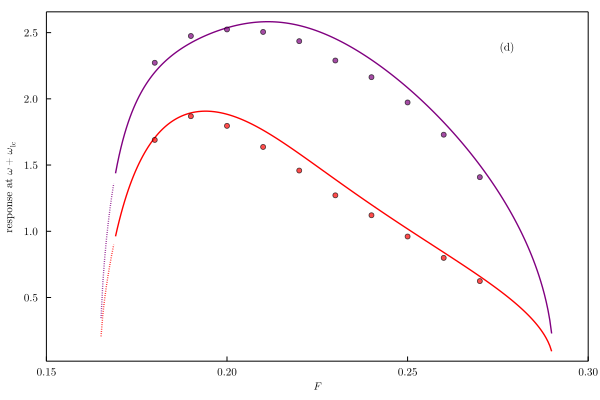

In [9]:
p4 = plot1D(result, x="F0", y="sqrt(u3^2+v3^2)", ylabel="oscillator 1, left sidepeak", 
    plot_only=["physical"], branches=[4], c=:red, xlim=(0.15,0.3), xticks=[0.15,0.20,0.25,0.30])
annotate!((0.85,0.9), text("(d)", 7, "Computer Modern"))

plot1D(result, x="F0", y="abs(u6)", ylabel="response at \$ \\omega +  \\omega_{\\textrm{lc}} \$", plot_only=["physical"], branches=[4], c=:purple, add=true)

RK_peaks = [p[3][1] for p in pks]
Plots.scatter!(F0s, RK_peaks, opacity=0.7, c=:red)

RK_peaks = [p[3][3] for p in pks]
Plots.scatter!(F0s, RK_peaks, opacity=0.7, c=:purple)

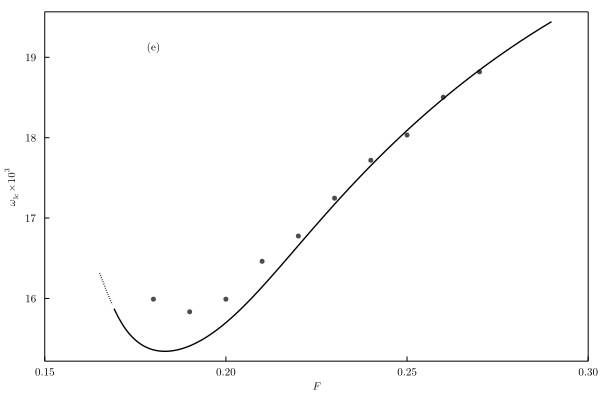

In [10]:
p5 = plot1D(result, x="F0", y="1000*abs(Δω)", ylabel="\$  \\omega_{\\textrm{lc}} \\: × \\: 10^{3}\$", 
    xlim=(0.15,0.3), plot_only=["physical"], branches=[4], c=:black,xticks=[0.15,0.20,0.25,0.30])
annotate!((0.2,0.9), text("(e)", 7, "Computer Modern"))

RK_peaks = 1000 .* ([p[3][4] for p in pks] .- 1.03 )
Plots.scatter!(F0s, RK_peaks, opacity=0.7, c=:black)

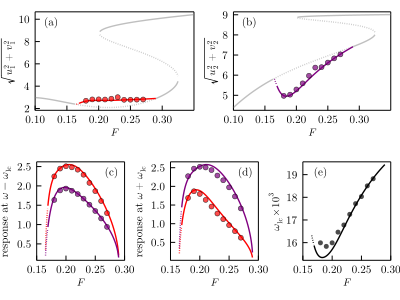

In [11]:
l = @layout [ a b ; c d e ]
all = Plots.plot(p1, p2, p3, p4, p5, layout = l, size=(400,300), right_margin=0.35mm,left_margin=-1.2mm)

In [12]:
savefig(all, dir * "limit_cycles/lc_ansatz.svg")

# Geometric phase work

In [5]:
result = HarmonicBalance.load("/home/hrochan/Downloads/2_Duff_lc_omega_overdamped.jld2")

A steady state result for 200 parameter points

Solution branches:   2156
   of which real:    10
   of which stable:  6

Classes: stable, physical, Hopf, binary_labels


In [6]:
ωs = LinRange(1.026,1.04,11)
ω_pks = [steady_peaks(F0fin=0.2, ω_drive=o, T=1E5) for o in ωs];

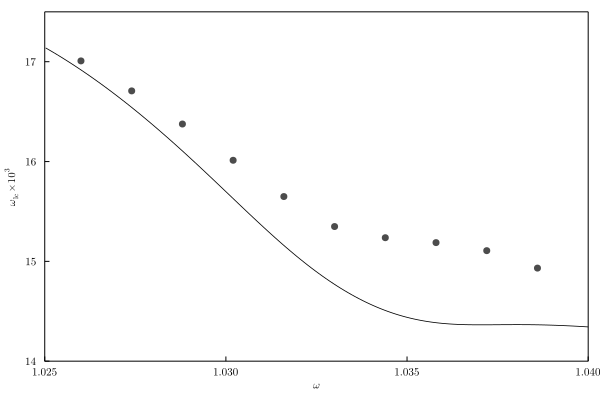

In [7]:
plot_gradient = plot1D(result, x="ω", y="1000*abs(Δω)", plot_only=["stable"], xlim=(1.025,1.04), c=:black,
    ylim=(14,17.5), branches=[5], xlabel="\$ \\omega \$", ylabel="\$ \\omega_{\\textrm{lc}} \\: × \\: 10^{3} \$",
yticks=14:17)
RK_data = [p[3][4] for p in ω_pks] .- ωs
Plots.scatter!(ωs, 1000 .* RK_data, c=:black, opacity=0.7)

In [8]:
using Interpolations

ωs_all = real.(getindex.(transform_solutions(result, "ω"),1))
Δωs_all = real.(getindex.(transform_solutions(result, "abs(Δω)"), 5));

interp_HC = interpolate((ωs_all,), Δωs_all, Gridded(Linear()))
interp_RK = interpolate((ωs, ), RK_data, Gridded(Linear()));

println("gradient HC: ", first(gradient(interp_HC, 1.03)))
println("gradient RK: ", first(gradient(interp_RK, 1.03)))

gradient HC: -0.34600045953325775
gradient RK: -0.25948210174037634


In [9]:
fft_window(data) = HarmonicBalance.TimeEvolution.DSP.Windows.hamming(length(data))

function geo_phase(θfin; T=3E4, ω_drive = 1.03)
    p0 = steady_fft(F0fin= 0.2, ω_drive = ω_drive, θfin=θfin, T=T);
    peaks = HarmonicBalance.TimeEvolution.FFT_analyze(p0[1][1][1].*0.5E-4, p0[1][2])
    
    # pick closest peak
    closest = argmin(abs.(peaks[1] .- 1.0139)) # read from the ω - Δω peak (it's large)
    -peaks[3][closest]
end

geo_phase (generic function with 1 method)

In [10]:
phases= 0:2pi:8pi
gps = geo_phase.(phases, T=1E5)

5-element Vector{Float64}:
 -2.2165254734928475
 -4.1853062859936925
  0.64021256688257
 -0.8703381583155805
 -2.5143873530548255

gradient of the phases: -0.2650293634344901


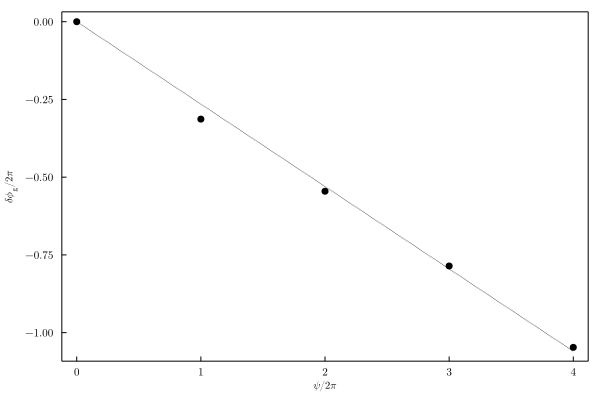

In [11]:
line_p = gps .+ [2pi,2pi,0,0,0]
line_p = line_p .- line_p[1]

g = phases \ line_p
println("gradient of the phases: ", g)

expected_line = ( phases .* g )

plot_phase = Plots.scatter(phases ./ (2pi), line_p ./ (2pi), 
    xlabel="\$ \\psi / 2 \\pi \$", ylabel = "\$ \\delta \\phi_{\\textrm{g}} / 2 \\pi\$", xlim=:automatic, c=:black)
Plots.plot!(phases ./ (2pi), expected_line ./(2pi), style=:dot, c=:black)
# add multiples of 2pi to make this a line
# plot alongside the ''expected'' line

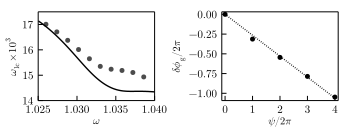

In [82]:
plot_geophase = Plots.plot(plot_gradient, plot_phase, size=(350,130))

In [83]:
savefig(plot_geophase, dir * "limit_cycles/geophase.svg")